# Exploration of Car Make and Violation Description Data from The City of Los Angeles Parking Citation Open Dataset

Based on [previous explorations](https://github.com/hackforla/lucky-parking/tree/citation-analysis/notebooks/exploratory) of the Los Angeles Parking Citation Open Dataset, it was found that parking citation violation types varied greatly by car make. This exploration will repeat that analysis and look at picking the best features for a model for users to interact with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from pathlib import Path
import random
import seaborn as sns

# Load project directory
PROJECT_DIR = Path(os.path.abspath('../..'))

In [2]:
# Load already cleaned data from makefile command
# 20% sampled from raw dataset
# Only make and violation_description columns
df = pd.read_csv(PROJECT_DIR / 'data' / 'processed' / '2021-01-02_processed_02samp.csv', index_col=0)
df.head()

,make,violation_description
index,,
0,Chevrolet,NO STOPPING/STANDING
1,Honda,NO PARKING
2,Toyota,NO EVIDENCE OF REG
3,Honda,RED ZONE
4,Hyundai,NO EVIDENCE OF REG


In [3]:
# Examine missing data
df.isna().sum()/len(df)*100

make                     0.185939
violation_description    0.888983
dtype: float64

In [4]:
# Drop all missing data
df.dropna(inplace=True)

In [5]:
# Create table of violation ratio by make
make_vio_dict = {}
for make in df.make.value_counts().head(40).index:
  counts = df.loc[(df.make == make), 'violation_description'].value_counts()
  count_ratio = counts/counts.sum()
  make_vio_dict[make] = count_ratio.to_dict()
make_ratio = pd.DataFrame.from_dict(make_vio_dict).T.fillna(0)

In [6]:
# Show table of violation ratios
make_ratio.head(10).style.background_gradient(cmap='Blues').format("{:.3f}")

In [7]:
sns.heatmap(make_ratio.iloc[[:10]].corr())

SyntaxError: invalid syntax (<ipython-input-7-9c49cafd910e>, line 1)

In [9]:
# Find principal component of violation ratio data using one component
pca = PCA(n_components=6)
make_pca = pd.DataFrame(data = pca.fit_transform(make_ratio)
             , columns = [f'Principal_Component_{n + 1}' for n in range(6)], index = make_ratio.index)
make_pca.head()

,Principal_Component_1,Principal_Component_2,Principal_Component_3,Principal_Component_4,Principal_Component_5,Principal_Component_6
Toyota,-0.055167,-0.043065,-0.012869,-0.017384,0.001551,0.009086
Honda,-0.054152,-0.052261,-0.010619,-0.007311,-0.002062,0.009455
Ford,-0.022620,-0.048478,0.002193,0.005117,-0.001114,0.000379
Nissan,-0.027387,-0.043421,-0.011723,-0.008799,0.000684,0.010982
Chevrolet,-0.013239,-0.046276,-0.000006,0.007753,0.000997,0.003121


[]

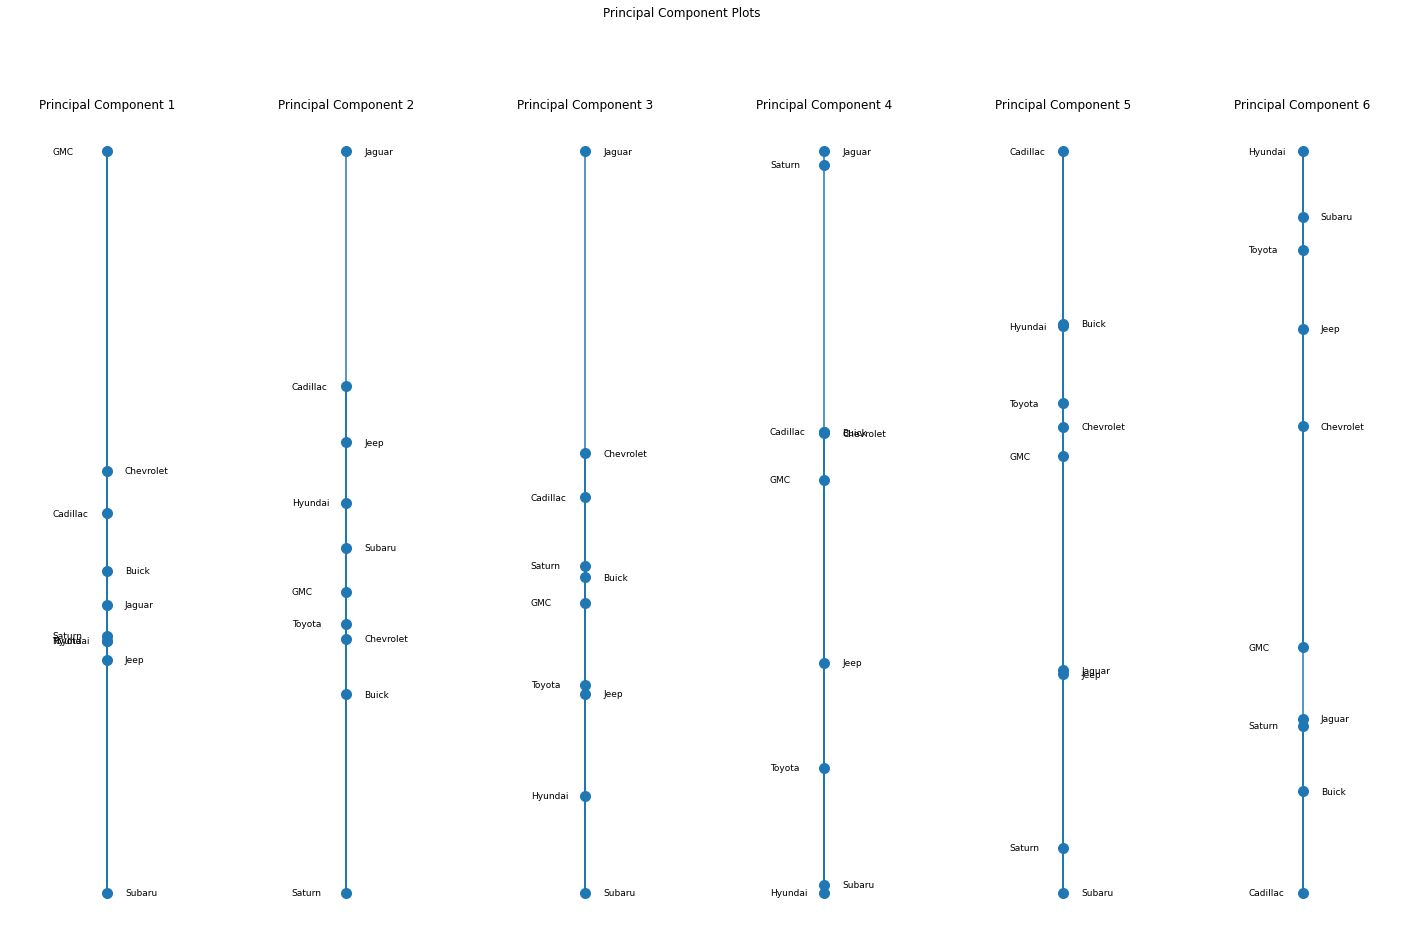

In [10]:
fig, axes = plt.subplots(1, 6, figsize=(25,15))
fig.suptitle('Principal Component Plots')

for ind, ax in enumerate(axes):
    subset = make_pca.iloc[::4, ind]
    # Add line return to Mercedes Benz
    subset.rename(index={'Mercedes Benz': 'Mercedes\nBenz'}, inplace=True)
    ax.plot(np.zeros(len(subset)), subset, marker='.', markersize=20)
    ax.axis('off')
    ax.set_title(f'Principal Component {ind+1}')
    for i, txt in enumerate(subset.index):
        if i%2 == 0:
            ax.annotate(txt, (-0.03, subset.iloc[i]), fontsize=9, va='center')
        else: 
            ax.annotate(txt, (0.01, subset.iloc[i]), fontsize=9, va='center')

plt.plot()

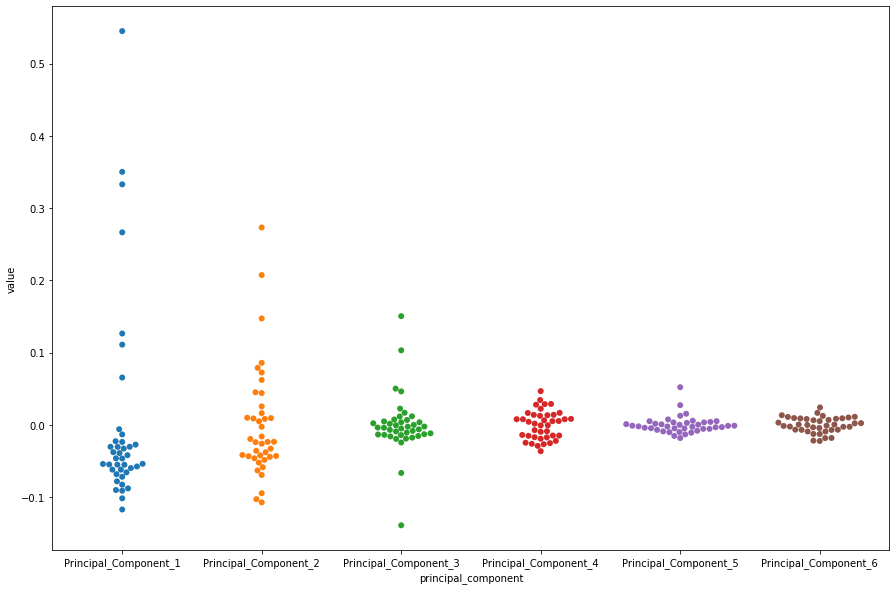

In [498]:
plt.figure(figsize=(15,10))
sns.swarmplot(x='principal_component' , y='value', data=pd.melt(make_pca.reset_index(), id_vars=['index'], var_name='principal_component'), size=6)
plt.show()

In [496]:
# Print explained variance ratio
pca.explained_variance_ratio_

array([0.69397733, 0.21524781, 0.06108238, 0.01408682, 0.00505293,
       0.00407453])

In [519]:
make_ratio.iloc[::3,0]

Toyota           0.315128
Nissan           0.299247
Mercedes Benz    0.227527
Dodge            0.280482
Jeep             0.293628
Other            0.085696
Chrysler         0.299885
Volvo            0.305666
Cadillac         0.258221
Unknown          0.196950
Lincoln          0.284800
Grumman          0.002125
Jaguar           0.232966
International    0.052588
Name: NO PARK/STREET CLEAN, dtype: float64

In [414]:
# Examine principal component weights
pca_components = pd.DataFrame(pca.components_, columns=make_ratio.columns, index=[f'PCA_{n + 1}' for n in range(6)])
pca_components

,NO PARK/STREET CLEAN,METER EXP.,PREFERENTIAL PARKING,RED ZONE,DISPLAY OF TABS,NO PARKING,PARKED OVER TIME LIMIT,NO STOP/STANDING,WHITE ZONE,BLOCKING DRIVEWAY,...,80692A,TRAILER 6' HIGH,80361,8009H,WRG SD-DUAL RWY,6433K7,225115A,52011E,2121B,80694A
PCA_1,-0.525097,-0.351075,-0.173135,0.708991,-0.089628,0.039049,-0.031754,0.084440,-0.011364,-0.020266,...,0.000046,0.000046,0.000046,0.000046,-0.000004,-0.000008,-0.000012,-0.000009,0.000038,0.000098
PCA_2,-0.586933,0.684739,0.094680,-0.028489,-0.112766,-0.062982,-0.060313,-0.044120,0.011114,-0.033732,...,0.000004,0.000004,0.000004,0.000004,-0.000015,-0.000048,0.000147,-0.000067,-0.000061,0.000006
PCA_3,-0.407699,-0.342851,-0.167204,-0.626056,0.027136,0.216843,-0.051059,0.038042,-0.025715,-0.017546,...,0.000154,0.000154,0.000154,0.000154,0.000006,-0.000010,0.000023,0.000029,0.000157,0.000627
PCA_4,0.009647,-0.252701,-0.397184,0.012017,0.290399,-0.147936,0.039858,0.011549,0.000250,-0.018192,...,-0.000189,-0.000189,-0.000189,-0.000189,0.000058,0.000199,0.000137,0.000311,0.000242,-0.000457
PCA_5,-0.188022,0.161671,-0.177186,-0.080840,0.040613,0.131823,0.268591,0.246622,0.034670,-0.053720,...,-0.000239,-0.000239,-0.000239,-0.000239,0.000111,-0.000180,-0.000051,-0.000119,-0.000188,-0.000503
PCA_6,0.135754,-0.183393,0.129266,-0.010368,-0.657225,0.343890,0.112436,0.220456,0.026424,0.057672,...,0.000372,0.000372,0.000372,0.000372,-0.000160,-0.000173,0.000230,-0.000343,-0.000930,-0.000788


In [15]:
# PCA 2-component plot
plt.figure(figsize=(15,15))
plt.scatter(make_pca.iloc[:,0],make_pca.iloc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.margins(0.1)
for i, txt in enumerate(make_pca.index):
    plt.annotate(txt, (make_pca.iloc[i,0], make_pca.iloc[i,1]), fontsize=10, va='bottom')
plt.show()

ValueError: 'left' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'

In [400]:
# Principal component weight breakdown
pca2_components = pd.DataFrame(pca2.components_, columns=make_ratio.columns, index=['PCA_1', 'PCA_2'])
pca2_components.loc['PCA_2'].abs().sort_values(ascending=False).head(14)/sum(pca2_components.loc['PCA_2'].abs())*100

METER EXP.                27.748920
NO PARK/STREET CLEAN      23.785327
DISPLAY OF PLATES         15.476340
DISPLAY OF TABS            4.569814
PREFERENTIAL PARKING       3.836887
NO PARKING                 2.552341
PARKED OVER TIME LIMIT     2.444173
EXCEED 72HRS-ST            2.014230
NO STOP/STANDING           1.787973
NO EVIDENCE OF REG         1.717449
STANDNG IN ALLEY           1.491765
BLOCKING DRIVEWAY          1.366964
RED ZONE                   1.154531
FIRE HYDRANT               0.911061
Name: PCA_2, dtype: float64